<a href="https://colab.research.google.com/github/Eddy-Emmanuel/Anomaly-Detection-FastAI/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'anomaly-detection-dataset-eddy:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4910018%2F8270145%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240430%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240430T091507Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9b3681d36071309e4e19408edb8c20301f25755429459170e41d8c195795c8e5b4d6226fdc472c29daee38a146989b2a8a7a2e8aa900be3108f333e225cef6cd6ef5c901d72e8dc1f5ac98d44d99fd84f2bafbe1a87eab1c765735091cb0604cccfcc9ed48e3231d82846b12d42f0b242fd2d8fb4bcf35525ec4d7f807c46e49d234071a0a0f44f3b59c9352ea9f60ceee25d46a8a42dad8c53d3ccba1f65900be8c67fc373bcb5d17277be413c1c0d120c4d8e37a43ba0252963de0926f358d9f7c054333b2b61cc93fde6dc427fc075ef4a180b1232411805621fb1a9069a590fa8bc849dafb186c42e1d340322b0147ea9c648c5837edf44c9556f65a1028'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2971564 bytes downloaded
Downloaded and uncompressed: anomaly-detection-dataset-eddy
Data source import complete.


In [2]:
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd

from fastai.tabular.all import *

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [3]:
df_train = pd.read_csv("/kaggle/input/anomaly-detection-dataset-eddy/KDDTrain.csv")

print(df_train.shape)

df_train.head()

(125973, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class,num_learners
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [5]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,125973.0,287.144650,2.604515e+03,0.0,0.00,0.00,0.00,4.290800e+04
src_bytes,125973.0,45566.743000,5.870331e+06,0.0,0.00,44.00,276.00,1.379964e+09
dst_bytes,125973.0,19779.114421,4.021269e+06,0.0,0.00,0.00,516.00,1.309937e+09
land,125973.0,0.000198,1.408607e-02,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,125973.0,0.022687,2.535300e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,125973.0,0.000111,1.436603e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,125973.0,0.204409,2.149968e+00,0.0,0.00,0.00,0.00,7.700000e+01
num_failed_logins,125973.0,0.001222,4.523914e-02,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,125973.0,0.395736,4.890101e-01,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,125973.0,0.279250,2.394204e+01,0.0,0.00,0.00,0.00,7.479000e+03


In [6]:
df_test = pd.read_csv("/kaggle/input/anomaly-detection-dataset-eddy/KDDTest.csv")

print(df_test.shape)

df_test.head()

(22544, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class,num_learners
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [7]:
df_train.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_hot_login                   0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [8]:
df_test.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_hot_login                   0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

## BaseLine Model

In [9]:
categorical_columns = df_train.select_dtypes(include="O").columns[:-1]
numerical_columns =  df_train.select_dtypes(exclude="O").columns

In [10]:
categorical_columns

Index(['protocol_type', 'service', 'flag'], dtype='object')

In [11]:
numerical_columns.tolist()

['duration',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_hot_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'num_learners']

In [12]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df_train["attack_class"] = encoder.fit_transform(df_train["attack_class"])

In [13]:
class_indices = {i:j for i, j in zip(encoder.classes_, range(len(encoder.classes_)))}

class_indices

{'back': 0,
 'buffer_overflow': 1,
 'ftp_write': 2,
 'guess_passwd': 3,
 'imap': 4,
 'ipsweep': 5,
 'land': 6,
 'loadmodule': 7,
 'multihop': 8,
 'neptune': 9,
 'nmap': 10,
 'normal': 11,
 'perl': 12,
 'phf': 13,
 'pod': 14,
 'portsweep': 15,
 'rootkit': 16,
 'satan': 17,
 'smurf': 18,
 'spy': 19,
 'teardrop': 20,
 'warezclient': 21,
 'warezmaster': 22}

In [ ]:
train_dataset = TabularPandas(df=df_train,
                              procs=[Categorify, FillMissing, Normalize],
                              cat_names=categorical_columns.tolist(),
                              cont_names=numerical_columns.tolist(),
                              y_names="attack_class",
                              y_block = CategoryBlock,
                              splits=RandomSplitter(seed=42)(range_of(df_train)))

In [ ]:
train_dataloader = train_dataset.dataloaders(batch_size=2000, shuffle_train=True)

In [ ]:
train_dataloader.show_batch()

,protocol_type,service,flag,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_hot_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,num_learners,attack_class
0,tcp,http,REJ,0.000010,0.001156,0.000228,2.175145e-14,-2.015658e-10,-2.487235e-12,-7.313974e-09,4.314132e-11,-1.429553e-08,8.639370e-09,-1.840078e-11,1.535038e-11,9.741532e-09,4.361961e-10,1.818206e-11,-1.314002e-10,0.0,3.171802e-13,-2.134832e-10,0.999999,1.000001,-5.339865e-09,5.994000e-10,1.000000e+00,1.000000e+00,1.00,-1.227034e-09,-1.487016e-09,62.000003,255.000000,1.00,2.839795e-11,2.000000e-02,2.000000e-02,-3.909244e-09,9.999997e-03,1.000000e-01,3.000000e-02,21.0,11
1,udp,other,SF,6521.999877,145.999207,104.999560,2.175145e-14,-2.015658e-10,-2.487235e-12,-7.313974e-09,4.314132e-11,-1.429553e-08,8.639370e-09,-1.840078e-11,1.535038e-11,9.741532e-09,4.361961e-10,1.818206e-11,-1.314002e-10,0.0,3.171802e-13,-2.134832e-10,1.999999,2.000000,-5.339865e-09,5.994000e-10,-3.730913e-09,-3.567235e-09,1.00,-1.227034e-09,-1.487016e-09,255.000002,1.999995,0.01,4.400000e-01,7.200000e-01,-4.463142e-10,-3.909244e-09,3.258827e-09,-1.355306e-10,2.933473e-09,21.0,11
2,tcp,vmnet,REJ,0.000010,0.001156,0.000228,2.175145e-14,-2.015658e-10,-2.487235e-12,-7.313974e-09,4.314132e-11,-1.429553e-08,8.639370e-09,-1.840078e-11,1.535038e-11,9.741532e-09,4.361961e-10,1.818206e-11,-1.314002e-10,0.0,3.171802e-13,-2.134832e-10,244.999996,20.000000,-5.339865e-09,5.994000e-10,1.000000e+00,1.000000e+00,0.08,6.000000e-02,-1.487016e-09,255.000002,19.999998,0.08,7.000000e-02,1.943712e-09,-4.463142e-10,-3.909244e-09,3.258827e-09,1.000000e+00,1.000000e+00,19.0,9
3,tcp,ssh,S0,0.000010,0.001156,0.000228,2.175145e-14,-2.015658e-10,-2.487235e-12,-7.313974e-09,4.314132e-11,-1.429553e-08,8.639370e-09,-1.840078e-11,1.535038e-11,9.741532e-09,4.361961e-10,1.818206e-11,-1.314002e-10,0.0,3.171802e-13,-2.134832e-10,6.999999,3.000001,1.000000e+00,1.000000e+00,-3.730913e-09,-3.567235e-09,0.43,4.300000e-01,-1.487016e-09,255.000002,2.999995,0.01,9.000000e-02,1.943712e-09,-4.463142e-10,1.000000e+00,1.000000e+00,-1.355306e-10,2.933473e-09,19.0,9
4,tcp,smtp,SF,0.000010,762.001046,322.999554,2.175145e-14,-2.015658e-10,-2.487235e-12,-7.313974e-09,4.314132e-11,1.000000e+00,8.639370e-09,-1.840078e-11,1.535038e-11,9.741532e-09,4.361961e-10,1.818206e-11,-1.314002e-10,0.0,3.171802e-13,-2.134832e-10,0.999999,1.000001,-5.339865e-09,5.994000e-10,-3.730913e-09,-3.567235e-09,1.00,-1.227034e-09,-1.487016e-09,222.000000,148.000001,0.56,2.000000e-02,1.943712e-09,1.000000e-02,-3.909244e-09,3.258827e-09,-1.355306e-10,2.933473e-09,21.0,11
5,tcp,smtp,SF,0.000010,681.998971,333.999822,2.175145e-14,-2.015658e-10,-2.487235e-12,-7.313974e-09,4.314132e-11,1.000000e+00,8.639370e-09,-1.840078e-11,1.535038e-11,9.741532e-09,4.361961e-10,1.818206e-11,-1.314002e-10,0.0,3.171802e-13,-2.134832e-10,0.999999,1.000001,-5.339865e-09,5.994000e-10,-3.730913e-09,-3.567235e-09,1.00,-1.227034e-09,-1.487016e-09,47.000003,114.000000,0.38,6.000000e-02,2.000000e-02,2.000000e-02,-3.909244e-09,1.800000e-01,-1.355306e-10,2.933473e-09,18.0,11
6,tcp,http,SF,0.000010,232.999696,1295.000312,2.175145e-14,-2.015658e-10,-2.487235e-12,-7.313974e-09,4.314132e-11,1.000000e+00,8.639370e-09,-1.840078e-11,1.535038e-11,9.741532e-09,4.361961e-10,1.818206e-11,-1.314002e-10,0.0,3.171802e-13,-2.134832e-10,0.999999,1.000001,-5.339865e-09,5.994000e-10,-3.730913e-09,-3.567235e-09,1.00,-1.227034e-09,-1.487016e-09,29.000001,255.000000,1.00,2.839795e-11,3.000000e-02,2.000000e-02,-3.909244e-09,3.258827e-09,-1.355306e-10,2.933473e-09,21.0

In [ ]:
anomaly_learner = tabular_learner(train_dataloader, metrics=[accuracy, error_rate])

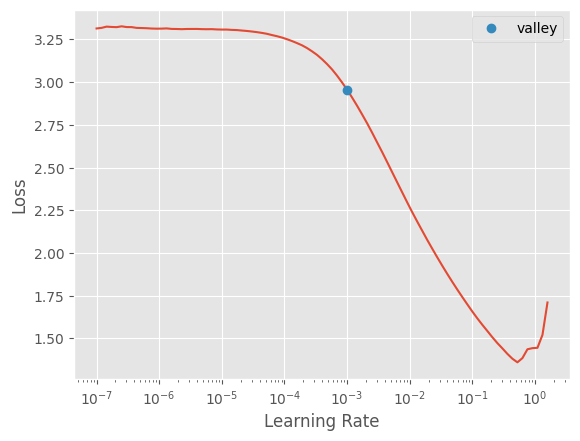

In [ ]:
best_lr = anomaly_learner.lr_find()

# Fit the model

In [ ]:
anomaly_learner.fine_tune(epochs=10, base_lr=best_lr[0])

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.531691,0.394239,0.945781,0.054219,00:02


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.280029,0.225966,0.966579,0.033421,00:02
1,0.175908,0.102326,0.989005,0.010995,00:02
2,0.097642,0.047513,0.993133,0.006867,00:02
3,0.055906,0.034809,0.995158,0.004842,00:01
4,0.035726,0.027515,0.995396,0.004604,00:02
5,0.025161,0.020588,0.996229,0.003771,00:02
6,0.019303,0.017612,0.996587,0.003414,00:02
7,0.015881,0.019141,0.996467,0.003533,00:01
8,0.014096,0.016991,0.996706,0.003294,00:01
9,0.013072,0.016091,0.996626,0.003374,00:02


In [ ]:
df_test["attack_class"] = df_test["attack_class"].map(class_indices)

In [ ]:
df_test.dropna(inplace=True)

In [ ]:
set(df_test["attack_class"].unique()) - set(df_train["attack_class"].unique())

set()

In [ ]:
df_test.reset_index(drop=True, inplace=True)

In [ ]:
df_test

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class,num_learners
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,9.0,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,9.0,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,11.0,21
3,0,tcp,http,SF,267,14515,0,0,0,0,...,1.00,0.00,0.01,0.03,0.01,0.0,0.00,0.00,11.0,21
4,0,tcp,smtp,SF,1022,387,0,0,0,0,...,0.11,0.72,0.00,0.00,0.00,0.0,0.72,0.04,11.0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18789,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,1.00,0.00,1.00,0.00,0.00,0.0,0.00,0.00,18.0,20
18790,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,11.0,21
18791,0,tcp,http,SF,317,938,0,0,0,0,...,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,11.0,21
18792,0,tcp,http,SF,54540,8314,0,0,0,2,...,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,0.0,15


In [ ]:
test_dataloader = anomaly_learner.dls.test_dl(df_test)

results = anomaly_learner.validate(dl=test_dataloader)

print(results)

[0.9149068593978882, 0.8418644070625305, 0.1581355780363083]


In [ ]:
print(f"Validation Loss: {results[0]} -- Accuracy: {results[1]} -- Error rate: {results[1]}")

Validation Loss: 0.9149068593978882 -- Accuracy: 0.8418644070625305 -- Error rate: 0.8418644070625305


In [ ]:
anomaly_learner.export("anomaly_learner.pkl")

# Combine dataset

In [39]:
comb_df = pd.concat([df_train, df_test], axis=0)

comb_df.shape

(148517, 43)

In [40]:
comb_dataset = TabularPandas(df=comb_df,
                             procs=[Categorify, FillMissing, Normalize],
                             cat_names=categorical_columns.tolist(),
                             cont_names=numerical_columns.tolist(),
                             y_names="attack_class",
                             y_block = CategoryBlock,
                             splits=RandomSplitter(seed=42)(range_of(comb_df)))

In [41]:
comb_dataloader = comb_dataset.dataloaders(shuffle_train=True)

In [42]:
comb_dataloader.show_batch()

,protocol_type,service,flag,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_hot_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,num_learners,attack_class
0,udp,domain_u,SF,0.000006,44.000940,129.999751,5.558549e-12,-6.326341e-10,-1.720229e-12,4.400020e-09,-2.110405e-11,-1.073876e-08,4.109067e-10,-5.116761e-11,-2.910030e-11,1.031730e-08,-4.794418e-10,2.173667e-11,-1.262431e-10,0.0,-4.292146e-13,1.421603e-10,68.000000,147.999996,1.009270e-08,-7.696347e-09,-9.080826e-10,-3.517310e-09,1.000000e+00,2.758615e-09,1.000000e-02,255.000000,254.000005,1.000000e+00,1.000000e-02,2.213465e-09,1.452207e-09,9.049607e-09,-9.206762e-09,-3.460646e-09,-2.722570e-09,20.0,11
1,tcp,private,S0,0.000006,-0.000502,0.000231,5.558549e-12,-6.326341e-10,-1.720229e-12,4.400020e-09,-2.110405e-11,-1.073876e-08,4.109067e-10,-5.116761e-11,-2.910030e-11,1.031730e-08,-4.794418e-10,2.173667e-11,-1.262431e-10,0.0,-4.292146e-13,1.421603e-10,282.000004,18.000000,1.000000e+00,1.000000e+00,-9.080826e-10,-3.517310e-09,5.999999e-02,4.000000e-02,1.268844e-09,255.000000,14.000000,5.000000e-02,5.000000e-02,2.213465e-09,1.452207e-09,1.000000e+00,1.000000e+00,-3.460646e-09,-2.722570e-09,21.0,9
2,icmp,ecr_i,SF,0.000006,1032.000292,0.000231,5.558549e-12,-6.326341e-10,-1.720229e-12,4.400020e-09,-2.110405e-11,-1.073876e-08,4.109067e-10,-5.116761e-11,-2.910030e-11,1.031730e-08,-4.794418e-10,2.173667e-11,-1.262431e-10,0.0,-4.292146e-13,1.421603e-10,511.000000,510.999990,1.009270e-08,-7.696347e-09,-9.080826e-10,-3.517310e-09,1.000000e+00,2.758615e-09,1.268844e-09,225.999999,132.000000,5.800000e-01,3.000000e-02,5.800000e-01,1.452207e-09,9.999994e-03,-9.206762e-09,2.800000e-01,-2.722570e-09,18.0,18
3,tcp,http,SF,0.000006,236.001088,273.999902,5.558549e-12,-6.326341e-10,-1.720229e-12,4.400020e-09,-2.110405e-11,1.000000e+00,4.109067e-10,-5.116761e-11,-2.910030e-11,1.031730e-08,-4.794418e-10,2.173667e-11,-1.262431e-10,0.0,-4.292146e-13,1.421603e-10,15.000002,15.000000,1.009270e-08,-7.696347e-09,-9.080826e-10,-3.517310e-09,1.000000e+00,2.758615e-09,1.268844e-09,14.999996,254.999994,1.000000e+00,-1.509118e-10,7.000000e-02,4.000000e-02,9.049607e-09,-9.206762e-09,-3.460646e-09,-2.722570e-09,21.0,normal
4,tcp,http,SF,0.000006,195.001408,11029.999956,5.558549e-12,-6.326341e-10,-1.720229e-12,4.400020e-09,-2.110405e-11,1.000000e+00,4.109067e-10,-5.116761e-11,-2.910030e-11,1.031730e-08,-4.794418e-10,2.173667e-11,-1.262431e-10,0.0,-4.292146e-13,1.421603e-10,0.999998,0.999999,1.009270e-08,-7.696347e-09,-9.080826e-10,-3.517310e-09,1.000000e+00,2.758615e-09,1.268844e-09,11.999994,254.999994,1.000000e+00,-1.509118e-10,8.000000e-02,2.000000e-02,9.049607e-09,-9.206762e-09,-3.460646e-09,-2.722570e-09,21.0,11
5,tcp,smtp,SF,0.000006,1131.998961,366.000616,5.558549e-12,-6.326341e-10,-1.720229e-12,4.400020e-09,-2.110405e-11,1.000000e+00,4.109067e-10,-5.116761e-11,-2.910030e-11,1.031730e-08,-4.794418e-10,2.173667e-11,-1.262431e-10,0.0,-4.292146e-13,1.421603e-10,0.999998,2.000000,1.009270e-08,-7.696347e-09,-9.080826e-10,-3.517310e-09,1.000000e+00,2.758615e-09,1.000000e+00,40.000000,148.000002,8.800000e-01,8.000000e-02,3.000000e-02,1.000000e-02,9.049607e-09,-9.206762e-09,-3.460646e-09,-2.722570e-09,21.0,11
6,tcp,echo,S0,0.000006,-0.000502,0.000231,5.558549e-12,-6.326341e-10,-1.720229e-12,4.400020e-09,-2.110405e-11,-1.073876e-08,4.109067e-10,-5.116761e-11,-2.910030e-11,1.031730e-08,-4.794418e-10,2.173667e-11,-1.262431e-10,0.0,-4.292146e-13,1.421603e-10,256.999997,20.000000,1.000000e+00,1.000000e+00,-9.080826e-10,-3.517310e-09,8.000001e-02,6.000

In [43]:
comb_anomaly_learner = tabular_learner(comb_dataloader, metrics=[accuracy, error_rate])

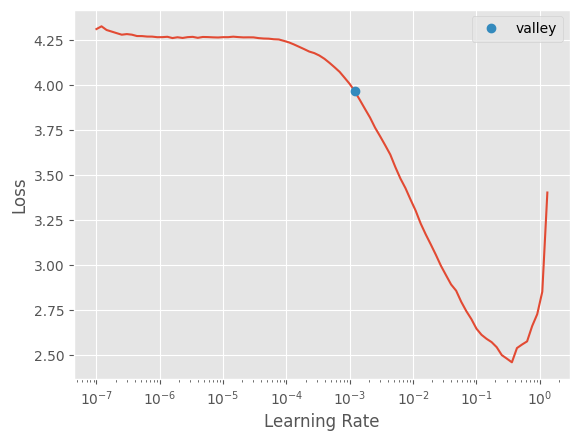

In [44]:
comb_best_lr = comb_anomaly_learner.lr_find()

In [47]:
comb_anomaly_learner.fine_tune(epochs=20, base_lr=comb_best_lr[0])

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.320928,5.954380,0.890886,0.109114,00:19


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.273495,3.827454,0.897384,0.102616,00:19
1,0.291996,4.719533,0.893815,0.106185,00:19
2,0.285875,9.283813,0.898360,0.101640,00:19
3,0.299570,2.071789,0.898125,0.101875,00:18
4,0.277751,0.773534,0.892704,0.107296,00:21
5,0.303475,13.770064,0.899404,0.100596,00:19
6,0.263787,11.200994,0.880887,0.119113,00:18
7,0.288703,8.936121,0.898495,0.101505,00:20
8,0.278628,13.719149,0.902266,0.097734,00:18
9,0.286128,11.391397,0.901862,0.098138,00:19


In [48]:
interpreter = ClassificationInterpretation.from_learner(comb_anomaly_learner)

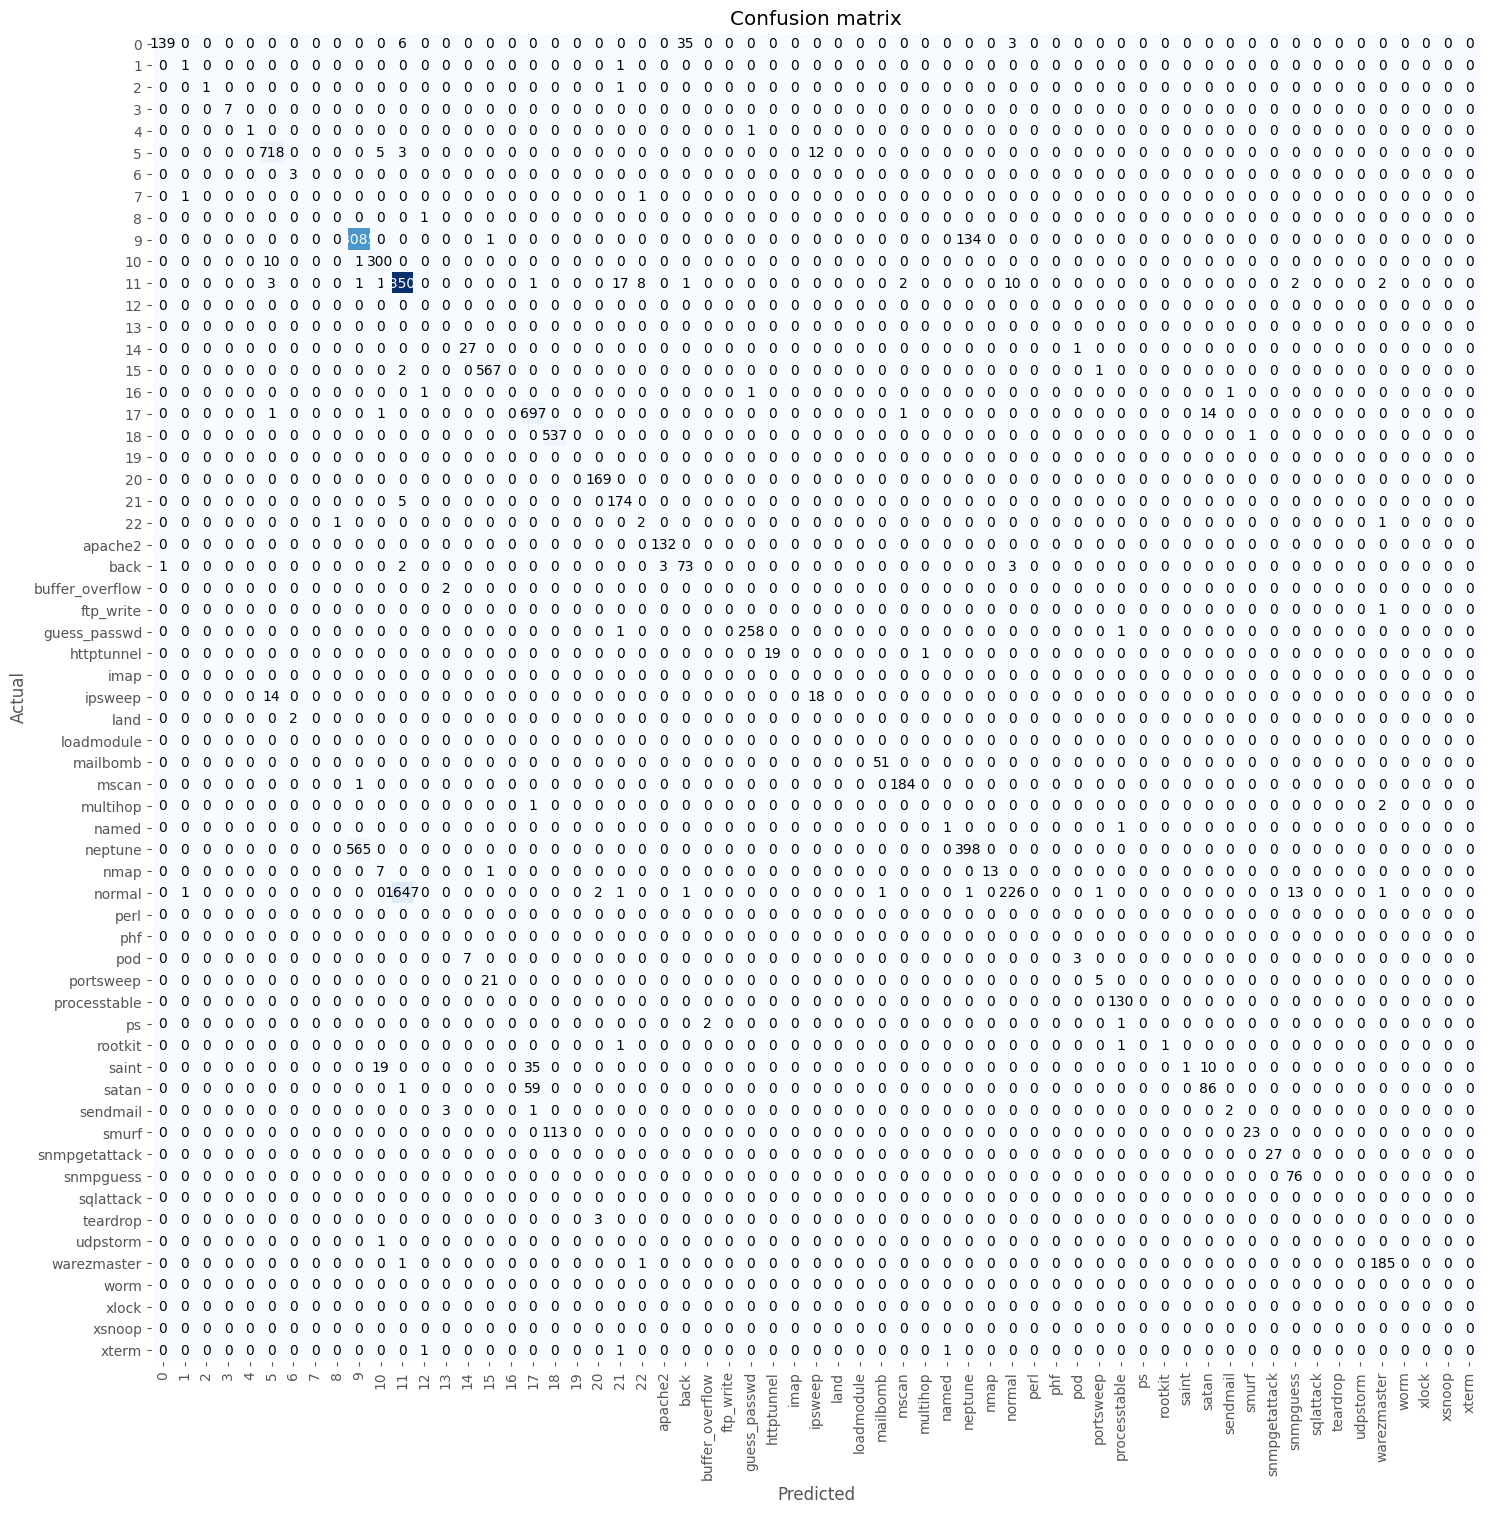

In [51]:
interpreter.plot_confusion_matrix(figsize=(15, 15))

In [50]:
interpreter.print_classification_report()

                 precision    recall  f1-score   support

              0       0.99      0.76      0.86       183
              1       0.33      0.50      0.40         2
              2       1.00      0.50      0.67         2
              3       1.00      1.00      1.00         7
              4       1.00      0.50      0.67         2
              5       0.96      0.97      0.97       738
              6       0.60      1.00      0.75         3
              7       0.00      0.00      0.00         2
              8       0.00      0.00      0.00         1
              9       0.93      0.98      0.96      8220
             10       0.90      0.96      0.93       311
             11       0.89      1.00      0.94     13554
             12       0.00      0.00      0.00         0
             13       0.00      0.00      0.00         0
             14       0.79      0.96      0.87        28
             15       0.96      0.99      0.98       570
             16       0.00    

## Eddy
